# World Models
**Jin Yeom**  
jin.yeom@hudl.com

In [1]:
from collections import namedtuple
from pprint import pprint

import gym
from gym.spaces import Box
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import animation as anime
from IPython.display import HTML
import torch
from torch import nn, distributions
from torch.nn import functional as F
from torch.utils import data

This notebook implements **[World Models](https://arxiv.org/abs/1803.10122)** (Ha & Schmidhuber, 2018). This work proposes a framework of model-based deep reinforcement learning. Two key differences in this work from more commonly seen deep RL algorithms (e.g., DQN, PPO, DDPG, etc.) are that 1) feature learning is separated from the controller, i.e., a world model agent isn't trained with a strange scheme of learning where it can only learn to see via reward signals, and 2) the agent's model is trained in an unsupervised fashion from its trajectory data; once trained, it can simulate the environment within a latent space (they describe this simulation as "dreaming").

The proposed agent consists of three components: the vision model ($V$) and the memory model ($M$), which together define the agent's world model, and a controller ($C$) for selecting actions. Ha and Schmidhuber chose to use a convolutional VAE for $V$ and a mixture density recurrent network for $M$, and a single layered network for $C$, which was evolved via CMA-ES. Note that their choice of architecture is more of a proof of concept and can be enhanced with more advanced algorithms.

Note that this notebook is going to be a long one, i.e., this work is a sort of an orchestra of works that have shown progress over the past few years: unsupervised learning for images, temporal prediciton and reinforcement learning. This means that we'll be implementing three different models, and then some more to put them together.

## Environment

We'll start with something simple: **Atari 2600 Pong**.

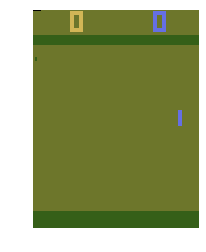

In [2]:
env = gym.make('PongNoFrameskip-v4')
obs = env.reset()
plt.imshow(obs)
plt.axis('off')
plt.show()

Before we start working with the environment, we'll preprocess the observation a little bit. Particularly, I think the scoreboard on top of the screen is rather irrelevant, so we'll crop it out; same for the bottom block.

In [3]:
class ProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, size):
        super(ProcessFrame, self).__init__(env)
        self.size = size
        self.observation_space = Box(low=0, high=1, shape=(size, size, 3), dtype=np.float32)

    def observation(self, obs):
        obs = Image.fromarray(obs[34:194, :160, :])  # crop the center square
        obs = np.array(obs.resize((self.size, self.size), resample=Image.BILINEAR))
        return obs.astype(np.float32) / 255.0

We'll also apply frame skip to increase performance ([Braylan et al., 2015](http://nn.cs.utexas.edu/downloads/papers/braylan.aaai15.pdf)).

In [4]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, frame_skip):
        super(FrameSkip, self).__init__(env)
        self._frame_skip = frame_skip

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._frame_skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

    def reset(self):
        return self.env.reset()

Lastly, we have to ensure that the environment takes one hot actions, rather than scalars. This is simply because our controller takes one hot vectors as a part of its inputs.

In [5]:
class OneHotAction(gym.ActionWrapper):
    def __init__(self, env):
        super(OneHotAction, self).__init__(env)
        n = env.action_space.n
        self.action_space = Box(low=0, high=1, shape=(n,), dtype=np.float32)
        
    def action(self, action):
        return np.argmax(action, axis=-1)

Now, we can compile these wrappers together with `gym.make` to make a single `make_pong` function. Nothing important, just neat to have!

In [6]:
def make_pong():
    env = gym.make('PongNoFrameskip-v4')
    env = ProcessFrame(env, 64)
    env = FrameSkip(env, 4)
    env = OneHotAction(env)
    return env

Let's take a look at observations from our processed environment.

In [7]:
env = make_pong()
fig = plt.figure()
plt.axis('off')
ims = []
obs = env.reset()
for _ in range(64):
    action = torch.from_numpy(env.action_space.sample())
    obs, _, _, _ = env.step(action)
    ims.append([plt.imshow(obs, animated=True)])
anim = anime.ArtistAnimation(fig, ims, interval=25, blit=True)
plt.close()
HTML(anim.to_html5_video())

## VAE (V) model

Our $V$ model will have the same architecture as from the paper.

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = F.relu(self.conv3(x), inplace=True)
        x = F.relu(self.conv4(x), inplace=True)
        x = x.view(x.size(0), -1)
        return self.fc_mean(x), self.fc_logvar(x)

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 5, stride=2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x), inplace=True)
        x = x.view(x.size(0), 1024, 1, 1)
        x = F.relu(self.deconv2(x), inplace=True)
        x = F.relu(self.deconv3(x), inplace=True)
        x = F.relu(self.deconv4(x), inplace=True)
        x = torch.sigmoid(self.deconv5(x))

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        if self.training:
            return self.reparameterize(mu, logvar)
        return mu
        
    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return eps.mul(sigma).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_ = self.decoder(z)
        return mu, logvar, z, x_

## Memory (M) model

This is the exciting part! Our agent's ability to predict the future based on its action is, in fact, the essence of a world model.

In [11]:
class MixtureDensityLSTM(nn.Module):
    def __init__(self, latent_dim, hid_dim, act_dim, num_mixtures=5):
        super(MixtureDensityLSTM, self).__init__()
        self.latent_dim = latent_dim
        self.hid_dim = hid_dim
        self.act_dim = act_dim
        self.lstm = nn.LSTM(latent_dim + act_dim, hid_dim)
        # mixture density network
        self.num_mixtures = num_mixtures
        self.fc_pi = nn.Linear(hid_dim, num_mixtures * self.latent_dim)
        self.fc_mean = nn.Linear(hid_dim, num_mixtures * self.latent_dim)
        self.fc_logvar = nn.Linear(hid_dim, num_mixtures * self.latent_dim)

    def init_state(self):
        return (torch.zeros(1, 1, self.hid_dim), torch.zeros(1, 1, self.hid_dim))

    def mixture_coef(self, x):
        pi = F.softmax(self.fc_pi(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim), dim=2)
        mean = self.fc_mean(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim)
        logvar = self.fc_logvar(x).view(x.size(0), -1, self.num_mixtures, self.latent_dim)
        return pi, mean, logvar

    def sample(self, pi, mean, logvar):
        stdev = torch.exp(0.5 * logvar)
        return torch.sum(pi * torch.normal(mean, stdev), dim=2)

    def forward(self, z, a, h, c):
        z = torch.cat([z, a], dim=-1)
        z, (h, c) = self.lstm(z, (h, c))
        return self.mixture_coef(z), (h, c)

## Controller (C) model

Once again, Ha and Schmidhuber used CMA-ES to evolve the controller, but that's not a requirement. Since our problem environment is simple enough, we'll use the single threaded **A2C** (Advantage Actor-Critic) algorithm to train our controller.

Now that we decided to use an Actor-Critic agent, we may ask a question: since different components of the agent is trained asynchronously (i.e., first $V$ and/or $M$, then the $C$), when should the critic network be trained? When training the world model, or the controller? We'll try that later.

In [12]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, act_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Linear(state_dim, act_dim)
        self.critic = nn.Linear(state_dim, 1)
    
    def act(self, x):
        pi = F.softmax(self.actor(x), dim=-1)
        dist = distributions.OneHotCategorical(pi)
        return dist.sample()
    
    def value(self, x):
        return self.critic(x).detach()
    
    def forward(self, x):
        pi = F.softmax(self.actor(x), dim=-1)
        dist = distributions.OneHotCategorical(pi)
        action = dist.sample()
        logpi = dist.log_prob(action)
        entropy = dist.entropy()
        return action, logpi, entropy, self.value(x)

## Agent

Now, we can put together an agent! Pay special attention to how the agent makes an action.

In [13]:
class Agent:
    def __init__(self, vision, memory, controller, device=None):
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device
        self.vision = vision.to(self.device)
        self.memory = memory.to(self.device)
        self.controller = controller.to(self.device)
        h, c = self.memory.init_state()
        self._h = h.to(self.device)
        self._c = c.to(self.device)
        
    def act(self, x):
        x = torch.from_numpy(x.transpose(2, 0, 1))
        x = x.unsqueeze(0).to(self.device)  # add batch dimension
        z = self.vision.encode(x).unsqueeze(0)  # add time dimension
        s = torch.cat([z, self._h, self._c], dim=-1)
        a = self.controller.act(s)
        _, (h, c) = self.memory(z, a, self._h, self._c)
        self._h = h.detach()
        self._c = c.detach()
        # numpy one hot vector
        return a.squeeze().cpu().numpy()

In [14]:
latent_dim = 16
hid_dim = 32
act_dim = env.action_space.shape[0]
state_dim = latent_dim + hid_dim * 2

vision = VAE(latent_dim)
memory = MixtureDensityLSTM(latent_dim, hid_dim, act_dim)
controller = ActorCritic(state_dim, act_dim)

agent = Agent(vision, memory, controller)
print(f"device = {agent.device}")

device = cuda


Going back to the environment, let's see if our newly born agent can interact with the game.

In [15]:
env = make_pong()
fig = plt.figure()
plt.axis('off')
ims = []
obs = env.reset()
for _ in range(64):
    action = agent.act(obs)
    obs, reward, done, _ = env.step(action)
    ims.append([plt.imshow(obs, animated=True)])
anim = anime.ArtistAnimation(fig, ims, interval=25, blit=True)
plt.close()
HTML(anim.to_html5_video())

Alright, we can move on to data collection then.

## Data collection

In this section, we let the agent collect the environment data to train its world model. Since we're only interested in transition data ($s_t, a_t, s_{t+1}, a_{t+1}, ...$),

In [16]:
Transition = namedtuple('Transition', ['action', 'obs'])

**Note**: as you can see below, our `TransitionBuffer.reset` takes the first observation, returned by `env.reset()`. This means that each time a transition $\tau_t$ is pushed into the buffer, `transition.obs` is not $o_t$ but $o_{t+1}$.

In [17]:
class TransitionBuffer(data.Dataset):
    def __init__(self, env, capacity):
        self.capacity = capacity
        self.obs = np.zeros((self.capacity+1, *env.observation_space.shape))
        self.action = np.zeros((self.capacity, *env.action_space.shape))
        self._t = 0

    @property
    def full(self):
        return self._t == self.capacity

    def reset(self, obs):
        self.obs.fill(0)
        self.action.fill(0)
        self._t = 0
        self.obs[self._t] = obs

    def push(self, transition):
        assert not self.full
        self.obs[self._t+1] = transition.obs
        self.action[self._t] = transition.action
        self._t += 1
    
    def __getitem__(self, i):
        return self.obs[i], self.action[i]
    
    def __len__(self):
        return self.capacity

In [18]:
class ObservationSampler(data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source))
        for i in range(0, len(indices), self.batch_size):
            batch = []
            for j in indices[i:i+self.batch_size]:
                batch.append(self.data_source[j][0])
            batch = np.stack(batch)
            yield torch.from_numpy(batch)

    def __len__(self):
        num_data_points = len(self.data_source)
        last = int(num_data_points % self.batch_size > 0)
        return num_data_points // self.batch_size + last

In [19]:
buffer = TransitionBuffer(env, 10000)
sampler = ObservationSampler(buffer, 16)

In [20]:
def explore(env, agent, buffer):
    obs = env.reset()
    buffer.reset(obs)
    while not buffer.full:
        with torch.no_grad():
            action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        buffer.push(Transition(action=action, obs=obs))
        if done:
            obs = env.reset()

In [21]:
explore(env, agent, buffer)